# Implementation of a trading strategy using tick data from 2 exchanges

**Initial assumptions:** 
- stock_A and stock_B are traded on different exchanges 
- it is assumed that the price changes in stock_A anticipate similar price changes in stock_B
- the latency at which we are able to pass data and trade between the 2 exchanges is 40 milliseconds

**Tasks:**
- analyze the data to understand if the assumptions have any foundation
- implement and backtest a strategy in which stock_B is bought or sold according to price changes in stock_A


**Import visualization of data**

First we import the data from csv files. The data is organized for each stock with a column containing the timestamps and one containing the corresponding price for every tick throughout one trading day.

We merge the two datasets maintaining all the timestamps, this poses the problem of having many empty cells in our dataframe since timestamps for the 2 stocks rarely overlap. We front fill the empty price cells for each stock to maintain a true enough representation. A backfill is also needed to align on the very first timestamp.

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Read CSVs and convert timestamps to be indexes
stockA = pd.read_csv("stock_A.csv")
stockB = pd.read_csv("stock_B.csv")

stockA.timestamp = pd.to_datetime(stockA['timestamp'])
stockB.timestamp = pd.to_datetime(stockB['timestamp'])

stockA.set_index('timestamp', inplace=True)
stockB.set_index('timestamp', inplace=True)

# Merge datasets and replace NaN values with fronfill and backfill
stockTot = pd.merge(stockA, stockB, how = 'outer', left_index=True, right_index=True, sort = True, suffixes= ('_A', '_B'))
stockTot = stockTot.fillna(method = 'ffill')
stockTot = stockTot.fillna(method = 'bfill')

# Verify first rows
stockTot.head()


,price_A,price_B
timestamp,,
2019-05-23 08:00:00.537101596,100.644735,100.641682
2019-05-23 08:00:00.606442928,100.644735,100.641682
2019-05-23 08:00:01.375669956,100.053412,100.641682
2019-05-23 08:00:01.507983251,100.053412,100.055078
2019-05-23 08:00:02.180773020,100.302794,100.055078


To be able to visualize to have a visual representation of the data we resample the 2 timeseries into 5 minute intervals taking the latest price at each minute.

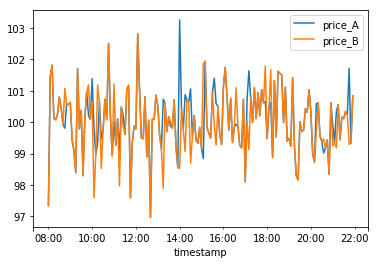

In [62]:
# Resample the data and plot
stockMinute = stockTot.resample('300s').last()
stockMinute.plot()

**Strategy feasibility**

Given our assumption of 40 millisecond latency for trading between the two exchanges it is useful to observe what is the average timestep between 2 ticks. This turns out to be above 600 milliseconds for both stocks, which gives assurance of being able to capture price movements in a timely manner.

In [57]:
# Create a series containing the timestamps for each stock 
# Calculate differences and take the mean
times_A = stockA.index.to_series()
times_A.reset_index(drop=True, inplace=True)
diffs_A = times_A.diff()
avg_A= diffs_A.mean()
stockA_timestep = avg_A.total_seconds()

times_B = stockB.index.to_series()
times_B.reset_index(drop=True, inplace=True)
diffs_B = times_B.diff()
avg_B= diffs_B.mean()
stockB_timestep = avg_B.total_seconds()

#print average timesteps
print(stockA_timestep, stockB_timestep)

0.633748258 0.647635945


**Checking for correlation**

To fact check our assumption we are going to measure correlation between the two timeseries. Since we know that both stocks have a new datapoint on average every 630-640 milliseconds, we resample the two timeseries into 300 millisecond intervals to be able to capture the variations of both stocks on our single timestamp series.

The correlation turns out to be fairly high and satisfactory enough to try out the strategy through backtesting.

In [77]:
#resample the 2 timeseries and merge them
stockA_reg = stockA.resample('300ms').last()
stockB_reg = stockB.resample('300ms').last()
stockTot_reg = pd.merge(stockA_reg, stockB_reg, how = 'outer', left_index=True, right_index=True, sort = True, suffixes= ('_A', '_B'))

#compute the correlation
corrs = stockTot_reg.corr()
corrs

,price_A,price_B
price_A,1.000000,0.892561
price_B,0.892561,1.000000


**Run Strategy**

Although our assumption is that stock_A influences stock_B and not _vice versa_ we will try backtesting the strategy both according to our assumption and in the inverse manner. 

The way the strategy is implemented is by choosing first a trigger value which will be the minimal value for which we can consider making a trade. Once that trigger is breached (e.g. stock_A rises or falls by a quantity larger than the trigger) the following steps are made:
- 40 millisecond latency period
- stock_B is bought if the move was up, sold if it was down
- stock_B is resold after next tick, locking in PnL update


In [85]:
# Set strategy values
exchange_latency = 40
latency = datetime.timedelta(milliseconds=exchange_latency)
trigger = 4.0
PnL = 0.0
PnL_arr = np.array([0])
PnL_inverse = 0.0
PnL_arr_inverse = np.array([0])

# Create series from the timestamps
times = stockTot.index.to_series()
times.reset_index(drop=True, inplace=True)

# Create series from the timestamps for each stock
timesA = stockA.index.to_series()
timesA.reset_index(drop=True, inplace=True)
timesB = stockB.index.to_series()
timesB.reset_index(drop=True, inplace=True)

# loop over the timesteps
for i in range(1, len(times)):
    
    # strategy as per initial assumption: buy/sell B given move in A
    if stockTot.price_A[i] - stockTot.price_A[i-1] > trigger:
        react_time = times[i] + latency #factor in the time the latency for transferring data
        price_index = timesB[timesB < react_time].idxmax() #select most recent timestep index
        PnL = PnL - stockB.price[price_index] + stockB.price[price_index + 1] #trade at nest timestep, update PnL
        PnL_arr = np.append(PnL_arr, PnL)
        
    if stockTot.price_A[i-1] - stockTot.price_A[i] > trigger:
        react_time = times[i] + latency
        price_index = timesB[timesB < react_time].idxmax()
        PnL = PnL + stockB.price[price_index] - stockB.price[price_index+1]
        PnL_arr = np.append(PnL_arr, PnL)
        
    # strategy inverted: buy/sell A given move in B   
    if stockTot.price_B[i] - stockTot.price_B[i-1] > trigger:
        react_time = times[i] + latency
        price_index = timesA[timesA < react_time].idxmax()
        PnL_inverse = PnL_inverse - stockA.price[price_index] + stockA.price[price_index + 1]
        
        PnL_arr_inverse = np.append(PnL_arr_inverse, PnL_inverse)
    if stockTot.price_B[i-1] - stockTot.price_B[i] > trigger:
        react_time = times[i] + latency
        price_index = timesA[timesA < react_time].idxmax()
        PnL_inverse = PnL_inverse + stockA.price[price_index] - stockA.price[price_index+1]
        PnL_arr_inverse = np.append(PnL_arr_inverse, PnL_inverse)

**Result 1**

The strategy following our assumptions ended up making money on the backtest.

337.02054308665276


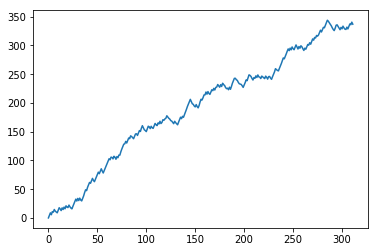

In [90]:
print(PnL)
plt.plot(PnL_arr)

**Result 2**

The inverse strategy ends up taking a loss, indicating that indeed throughout the day data, it is stock_A influencing stock_B's moves.

-245.24598188404747


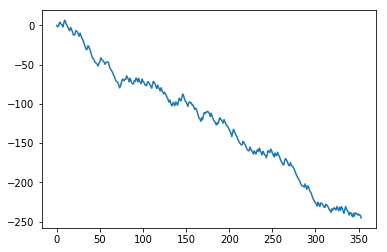

In [91]:
print(PnL_inverse)
plt.plot(PnL_arr_inverse)